In [1]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from prophet import Prophet

from sklearn.metrics import mean_squared_error, mean_absolute_error

from tqdm.notebook import tqdm

In [2]:
df = pd.read_csv('data_for_train/consumption_and_temperature_data.csv')
df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d %H:%M:%S')
df.set_index('datetime', inplace=True)
print('df.shape', df.shape)
df.head(2)

df.shape (64992, 2)


,one_hour_consumption,one_hour_temperature
datetime,,
2016-01-01 00:00:00,3962.983333,-8.313333
2016-01-01 01:00:00,3808.266667,-8.260000


Для предсказания потребления воспользуемся моделью Prophet. Для этого соответствующим образом подготовим данные для нашей модели:

In [3]:
df.reset_index(inplace=True)
df.rename(columns={'one_hour_consumption': 'y',
                   'datetime': 'ds'}, inplace=True)
df.drop('one_hour_temperature', axis=1, inplace=True)
print('df.shape', df.shape)
df.head(2)

df.shape (64992, 2)


,ds,y
0,2016-01-01 00:00:00,3962.983333
1,2016-01-01 01:00:00,3808.266667


Модель принимает данные единым пакетом и предсказывает хвост. Поэтому подготовим данные соответсвующим образом. Проверим модель на предсказание ею данные на последние полгода на следующие 36 часов. При этом для расчёта метрик будем брать последние 24 часа из предсказанных.

In [4]:
test_index = df[(df['ds'] >= '2022-11-30 11:00:00') & (df['ds'].dt.hour == 11)].index[:-1]

In [5]:
pd.DataFrame(df.iloc[test_index[0]]).T

,ds,y
60611,2022-11-30 11:00:00,5624.931579


In [6]:
pd.DataFrame(df.iloc[test_index[-1]]).T

,ds,y
64955,2023-05-30 11:00:00,4737.57552


Для каждого из временных моментов, вызовем модель и в конечном итоге получим предсказание на последние пол года.

In [7]:
df_true = df[df['ds'] >= '2022-12-01']
df_true.set_index('ds', inplace=True)
print('df_true.shape', df_true.shape)
df_true.head(2)

df_true.shape (4368, 1)


,y
ds,
2022-12-01 00:00:00,4285.977829
2022-12-01 01:00:00,4121.104164


In [8]:
df_pred = pd.DataFrame(index=df_true.index, data={'y_pred': np.nan})
print('df_pred.shape', df_pred.shape)
df_pred.head(2)

df_pred.shape (4368, 1)


,y_pred
ds,
2022-12-01 00:00:00,NaN
2022-12-01 01:00:00,NaN


In [9]:
for index in tqdm(test_index):

    train_df = df.iloc[:index + 1]
    model = Prophet()
    model.fit(train_df)
    future = model.make_future_dataframe(periods=36, freq='H')
    forecast = model.predict(future)

    df_pred['y_pred'].loc[forecast['ds'].iloc[-24:]] = forecast['yhat'].iloc[-24:].values

  0%|          | 0/182 [00:00<?, ?it/s]

21:13:30 - cmdstanpy - INFO - Chain [1] start processing
21:14:44 - cmdstanpy - INFO - Chain [1] done processing
21:15:22 - cmdstanpy - INFO - Chain [1] start processing
21:16:35 - cmdstanpy - INFO - Chain [1] done processing
21:17:13 - cmdstanpy - INFO - Chain [1] start processing
21:18:18 - cmdstanpy - INFO - Chain [1] done processing
21:18:55 - cmdstanpy - INFO - Chain [1] start processing
21:20:06 - cmdstanpy - INFO - Chain [1] done processing
21:20:43 - cmdstanpy - INFO - Chain [1] start processing
21:21:55 - cmdstanpy - INFO - Chain [1] done processing
21:22:32 - cmdstanpy - INFO - Chain [1] start processing
21:23:48 - cmdstanpy - INFO - Chain [1] done processing
21:24:25 - cmdstanpy - INFO - Chain [1] start processing
21:25:19 - cmdstanpy - INFO - Chain [1] done processing
21:25:56 - cmdstanpy - INFO - Chain [1] start processing
21:27:15 - cmdstanpy - INFO - Chain [1] done processing
21:27:52 - cmdstanpy - INFO - Chain [1] start processing
21:28:58 - cmdstanpy - INFO - Chain [1]

In [10]:
df_grouped_true = pd.DataFrame(df_true['y']).groupby([df_true.index.date, df_true.index.hour]).sum()
df_unstacked_true = df_grouped_true.unstack()
df_unstacked_true.index = pd.to_datetime(df_unstacked_true.index)

df_grouped_pred = pd.DataFrame(df_pred['y_pred']).groupby([df_pred.index.date, df_pred.index.hour]).sum()
df_unstacked_pred = df_grouped_pred.unstack()
df_unstacked_pred.index = pd.to_datetime(df_unstacked_pred.index)

In [11]:
def plot_predicts(df_true   : pd.DataFrame,
                  df_pred   : pd.DataFrame,
                  days_shift: int = 1) -> None:
    """
    Функция для отображения графиков
    принимает на вход датафреймы с инедксами с дневной резолюцией и 24 колнками,
    а также число дней, на которые нужно сдвинуть индексы для отображения
    """
    date_start = (df_true.index[0] + datetime.timedelta(days=days_shift)).date()
    date_end = (df_true.index[-1] + datetime.timedelta(days=days_shift)).date()

    print(f'Реальные и предсказанные значения за период {date_start} - {date_end}'.center(180, "-"))

    _, axes = plt.subplots(nrows=len(df_true)//7,
                           ncols=7,
                           figsize=(14, 2*len(df_true)//7 + 3))

    for i in range(len(df_true)//7):

        for j in range(7):

            ax = axes[i, j]

            ax.plot(range(24), df_true.iloc[i*7 + j], color='blue')
            ax.plot(range(24), df_pred.iloc[i*7 + j], alpha=0.5, color='red')
            
            ax.set_xticks(range(0, 24, 4))
            ax.set_yticks([])

            date = (df_true.index[i*7 + j] + datetime.timedelta(days=days_shift)).date()
            mae = mean_absolute_error(df_true.iloc[i*7 + j], df_pred.iloc[i*7 + j]).round(3)
            new_line = '\n'
            ax.set_title(f'{date}{new_line}MAE: {mae}')

    plt.tight_layout()
    plt.show()

    return None

In [12]:
print('MSE :', mean_squared_error(df_true['y'], df_pred['y_pred']).round(3))
print('MAE :', mean_absolute_error(df_true['y'], df_pred['y_pred']).round(3))

MSE : 78283.152
MAE : 226.67


--------------------------------------------------------Реальные и предсказанные значения за период 2022-12-01 - 2023-05-31---------------------------------------------------------


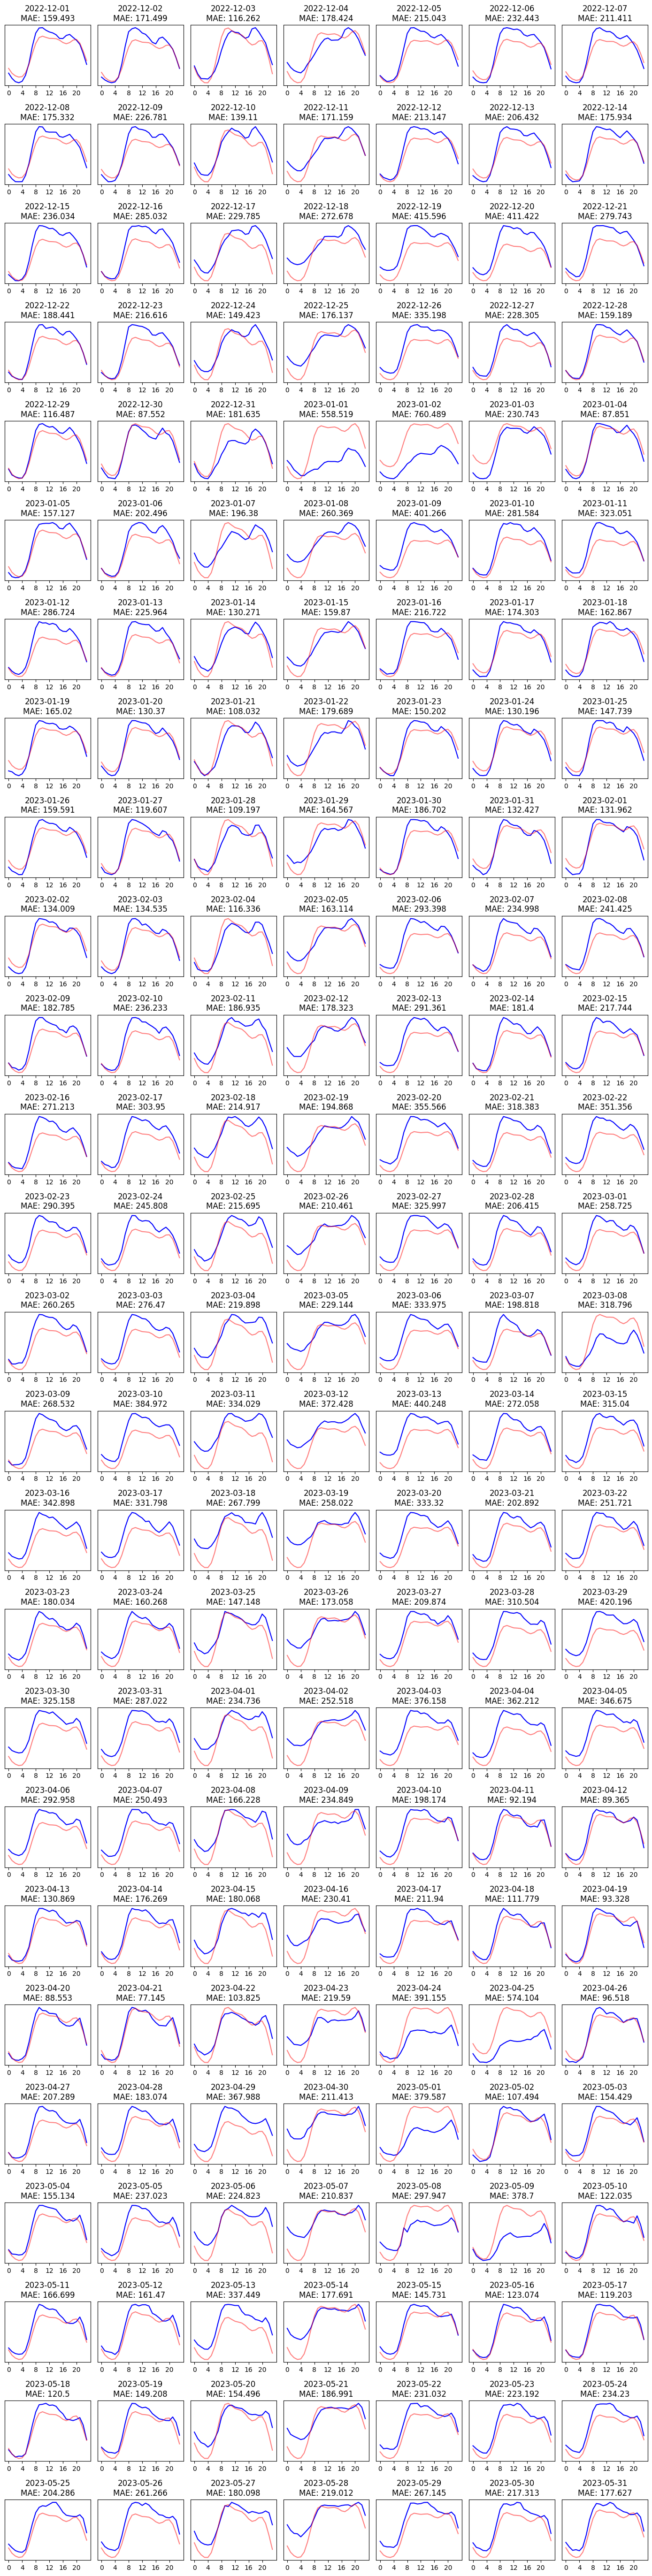

In [13]:
plot_predicts(df_true=df_unstacked_true,
              df_pred=df_unstacked_pred,
              days_shift=0)

Итоговый MAE на тестовых данных составил 226.670